In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification, ViTImageProcessor, Trainer, TrainingArguments

In [4]:
base_dir='/kaggle/input/ai-vs-human-generated-dataset/'
train_path=(base_dir+'train.csv')
test_path=(base_dir+'test.csv')

In [5]:
train_data=pd.read_csv(train_path)
test_data=pd.read_csv(test_path)

In [7]:
train_data.head()

,file_name,label
0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [6]:
train_data.drop(['Unnamed: 0'],inplace=True,axis=1)

### 1. Checking if file exists

In [8]:
file_name = "train_data/a6dcb93f596a43249135678dfcfc17ea.jpg"

# Check if the directory exists
print("Base directory exists:", os.path.exists(base_dir))

# Check if the file exists
print("File exists:", os.path.exists(os.path.join(base_dir, file_name)))

# List the first 10 files in the directory
print("Sample files:", os.listdir(base_dir)[:10])

Base directory exists: True
File exists: True
Sample files: ['test_data_v2', 'train.csv', 'test.csv', 'train_data']


### 2. Viewing images 

                                         file_name  label
0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1


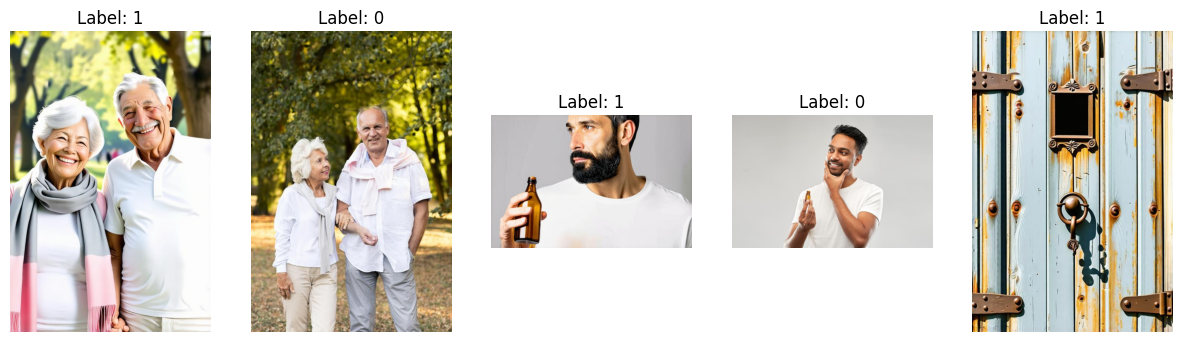

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

# Show first 5 rows
print(train_data.head())

# Function to display images
def show_images(num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        img_name = train_data.iloc[i, 0]  # Image filename
        label = train_data.iloc[i, 1]  # Label (AI or Human)
        img_path = os.path.join(base_dir, img_name)

        try:
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"Label: {label}")
            axes[i].axis("off")
        except Exception as e:
            print(f"Error loading {img_name}: {e}")

    plt.show()

# Call the function to display images
show_images(5)


In [10]:
# ---- LOAD IMAGE PROCESSOR ----
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [11]:
# ---- IMAGE TRANSFORMS ----
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std), 
])


### 3. Transforming images 

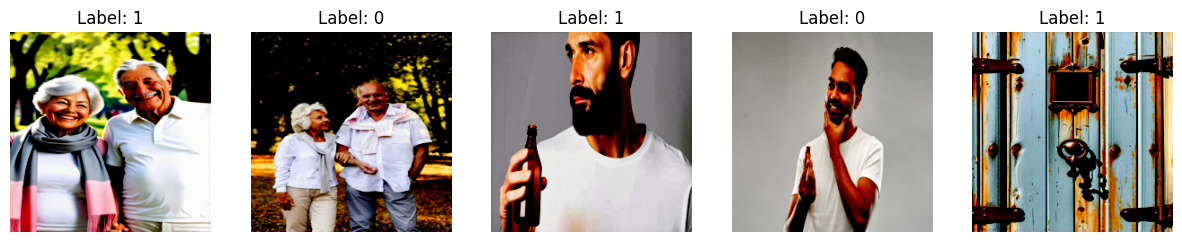

In [12]:
# Function to display transformed images
def show_transformed_images(num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        img_name = train_data.iloc[i, 0]
        img_path = os.path.join(base_dir, img_name)
        label = train_data.iloc[i, 1]

        img = Image.open(img_path)
        img = transform(img)  # Apply transformations

        # Convert tensor to numpy for visualization
        img = img.permute(1, 2, 0).numpy()

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    plt.show()

show_transformed_images(5)

In [13]:
# ---- CUSTOM DATASET CLASS ----
class ImageDataset(Dataset):
    def __init__(self, df, base_dir, transform=None, test=False):
        self.data = df
        self.base_dir = base_dir
        self.transform = transform
        self.test = test  # If test set, no labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.base_dir, self.data.iloc[idx, 0])  # Join base dir with image path
        image = Image.open(img_path).convert("RGB")  # Load image

        if self.transform:
            image = self.transform(image)

        if self.test:
            return {"pixel_values": image, "image_id": self.data.iloc[idx, 0]}  # No labels in test set
        else:
            label = self.data.iloc[idx, 1]  # Get label from CSV
            return {"pixel_values": image, "labels": torch.tensor(label, dtype=torch.long)}


In [14]:
# ---- LOAD DATA ----
dataset = ImageDataset(train_data, base_dir, transform)

In [15]:
# ---- SPLIT DATA (Train/Validation) ----
train_size = int(0.8 * len(dataset))  # 80% train, 20% validation
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [16]:
test_dataset = ImageDataset(test_data, base_dir, transform, test=True)


In [17]:
# ---- LOAD VIT MODEL ----
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2,  # Binary classification (AI vs Human)
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
# ---- TRAINING ARGS ---- Starting with 3 epochs
training_args = TrainingArguments(
    output_dir="./vit_output",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    report_to="none"
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [29]:
# ---- TRAINER ----
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor,
)


<ipython-input-29-a333134b48a7>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [30]:
os.environ["WANDB_DISABLED"] = "true"

# ---- TRAINING ----
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.003000,0.010030
2,0.000100,0.007613
3,0.000000,0.003859


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=11994, training_loss=0.010906892126095443, metrics={'train_runtime': 7391.4971, 'train_samples_per_second': 25.96, 'train_steps_per_second': 1.623, 'total_flos': 1.4869162967247913e+19, 'train_loss': 0.010906892126095443, 'epoch': 3.0})

In [35]:
trainer.save_model("./vit_output/checkpoint-best")

In [31]:
# ---- PREDICTIONS ON TEST DATA ----
def predict(model, dataset):
    dataloader = DataLoader(dataset, batch_size=16, shuffle=False)
    model.eval()  # Set model to eval mode
    predictions = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch["pixel_values"].to("cuda")  # Move to GPU if available
            outputs = model(inputs)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # Get predicted class
            predictions.extend(zip(batch["image_id"], preds))  # Store image_id with prediction

    return predictions


In [36]:
# ---- LOAD BEST MODEL ----
model = ViTForImageClassification.from_pretrained("./vit_output/checkpoint-best").to("cuda")


# ---- GENERATE SUBMISSION FILE ----
test_preds = predict(model, test_dataset)
submission = pd.DataFrame(test_preds, columns=["image_id", "label"])
submission.to_csv("submission.csv", index=False)

print("✅ Submission file saved as submission.csv")

✅ Submission file saved as submission.csv
